In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
file_path = '/content/drive/MyDrive/ids/iot23_combined.csv' # Replace your_file_name.csv with your actual file name
# Now, you can use the file_path variable as needed, for example in pd.read_csv
df = pd.read_csv(file_path)

In [ ]:
# Read a small sample to check it's working
df_check = pd.read_csv(file_path, nrows=5)
df_check.head()

,Unnamed: 0,ts,id.orig_h,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,0,1.540470e+09,192.168.1.132,0.003497,0,0,0.0,5.0,212.0,3.0,...,0,0,0,0,0,0,0,1,0,0
1,1,1.540470e+09,192.168.1.132,0.036724,34,311,0.0,1.0,62.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,2,1.540469e+09,192.168.1.132,384.518261,15072,0,0.0,48.0,16416.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,3,1.540470e+09,192.168.1.132,0.270332,48,48,0.0,1.0,76.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,4,1.540470e+09,192.168.1.132,0.111429,48,48,0.0,1.0,76.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Google Colab-compatible: Preprocessing Large CSV File in Chunks

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Set file path (you can use your actual file path here)
file_path = '/content/drive/MyDrive/ids/iot23_combined.csv'

# Parameters for chunking
chunk_size = 100000  # rows per chunk
selected_rows = []  # to store preprocessed chunks
start_row = 1  # skip header is row 0, so start from row 1
rows_to_read = 100000

# Loop through chunks
for i in range(5):  # example: load first 5 chunks (5 * 100000 = 5 lakh rows)
    print(f"Reading chunk {i+1}...")
    chunk = pd.read_csv(file_path, skiprows=range(1, start_row), nrows=rows_to_read)

    # Fill missing values instead of dropping
    chunk.fillna(-1, inplace=True)  # replace missing values with -1

    # Encode categorical columns
    for col in chunk.select_dtypes(include='object').columns:
        chunk[col] = chunk[col].astype(str)  # ensure string format
        chunk[col] = LabelEncoder().fit_transform(chunk[col])

    # Remove duplicates if any
    chunk.drop_duplicates(inplace=True)

    # Combine the chunk into the full list
    selected_rows.append(chunk)
    start_row += rows_to_read

# Combine all processed chunks into one DataFrame
df = pd.concat(selected_rows, ignore_index=True)

# Drop irrelevant or redundant columns if any (example shown)
drop_cols = ['Unnamed: 0'] if 'Unnamed: 0' in df.columns else []
df.drop(columns=drop_cols, inplace=True)

# Feature selection: Remove highly correlated features
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
df.drop(columns=to_drop, inplace=True)

# Normalize numerical features
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Ready for model training
y = df_scaled['label']  # assuming 'label' is the target
X = df_scaled.drop(columns=['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Preprocessing complete. Data ready for modeling.")


Reading chunk 1...
Reading chunk 2...
Reading chunk 3...
Reading chunk 4...
Reading chunk 5...
Preprocessing complete. Data ready for modeling.


In [ ]:
df_scaled.to_csv('cleaned_chunk.csv', index=False) # Save the processed data to cleaned_chunk.csv

In [ ]:
import pandas as pd

# Load the preprocessed 5 lakh dataset
df = pd.read_csv('cleaned_chunk.csv')  # Change to your actual file name

# Check number of rows
print(f"Total rows: {df.shape[0]}")

# Preview data
print(df.head())

Total rows: 500000
         ts  id.orig_h  duration    orig_bytes    resp_bytes  missed_bytes  \
0  0.402095   0.427419  0.000013  1.323686e-08  2.971624e-09           0.0   
1  0.402095   0.427419  0.000013  4.632901e-07  9.271466e-07           0.0   
2  0.402084   0.427419  0.004890  1.995192e-04  2.971624e-09           0.0   
3  0.402102   0.427419  0.000016  6.486061e-07  1.456096e-07           0.0   
4  0.402105   0.427419  0.000014  6.486061e-07  1.456096e-07           0.0   

   label  proto_icmp  proto_tcp  conn_state_OTH  ...  conn_state_RSTOS0  \
0    0.0         0.0        1.0             0.0  ...                0.0   
1    0.0         0.0        0.0             0.0  ...                0.0   
2    0.0         0.0        0.0             0.0  ...                0.0   
3    0.0         0.0        0.0             0.0  ...                0.0   
4    0.0         0.0        0.0             0.0  ...                0.0   

   conn_state_RSTR  conn_state_RSTRH  conn_state_S0  conn_sta

In [ ]:
# Total number of rows and columns after preprocessing
print(f"Total instances: {df.shape[0]}")
print(f"Total features: {df.shape[1]}")

Total instances: 500000
Total features: 22


WITHOUT NORMALIZATION AND FEATURE **SELECTION**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split features and label
X = df.drop('label', axis=1)
y = df['label']

# Convert the target variable to discrete values if necessary
# For example, if 'label' contains continuous values between 0 and 1,
# you can threshold it to create binary classes:
y = (y > 0.5).astype(int)  # Convert to 1 if > 0.5, else 0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[41114  5448]
 [   18 53420]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94     46562
           1       0.91      1.00      0.95     53438

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.94    100000
weighted avg       0.95      0.95      0.94    100000



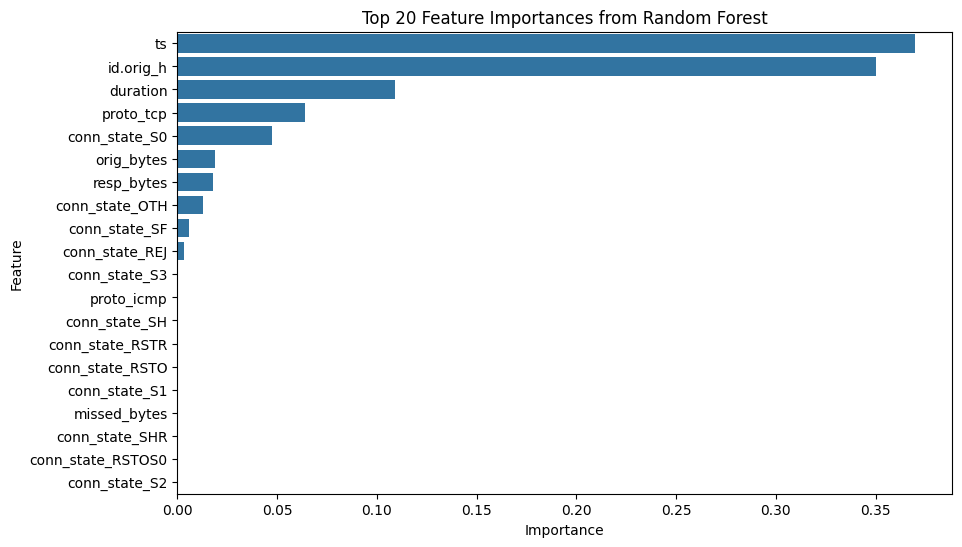

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Get feature importance
importances = rf_model.feature_importances_
features = X.columns
feat_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)
# Plot top 20
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(20))
plt.title('Top 20 Feature Importances from Random Forest')
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

# Assuming 'df' is your DataFrame containing the data
X = df.drop('label', axis=1)  # Features
y = df['label']  # Target variable

# Convert target to int if necessary
y = y.astype(int) # Make sure y contains integer class labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:03:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.99835
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     82906
           1       0.99      1.00      1.00     17094

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load your cleaned 5 lakh dataset (update path if needed)
df = pd.read_csv('cleaned_chunk.csv')

# Step 2: Separate features and label
X = df.drop(columns=['label'])  # Assuming 'label' is your target
y = df['label']

# Convert y to discrete values if it's continuous (important for Logistic Regression)
y = (y > 0.5).astype(int)  # Values above 0.5 become 1, others become 0
# Adjust the threshold (0.5) as needed for your problem

# Step 3: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train Logistic Regression model (no scaling)
logreg_model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
logreg_model.fit(X_train, y_train)  # Using unscaled data

# Step 5: Predict and Evaluate
y_pred = logreg_model.predict(X_test)  # Using unscaled data
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.79873
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72     46638
           1       0.73      1.00      0.84     53362

    accuracy                           0.80    100000
   macro avg       0.86      0.78      0.78    100000
weighted avg       0.85      0.80      0.79    100000



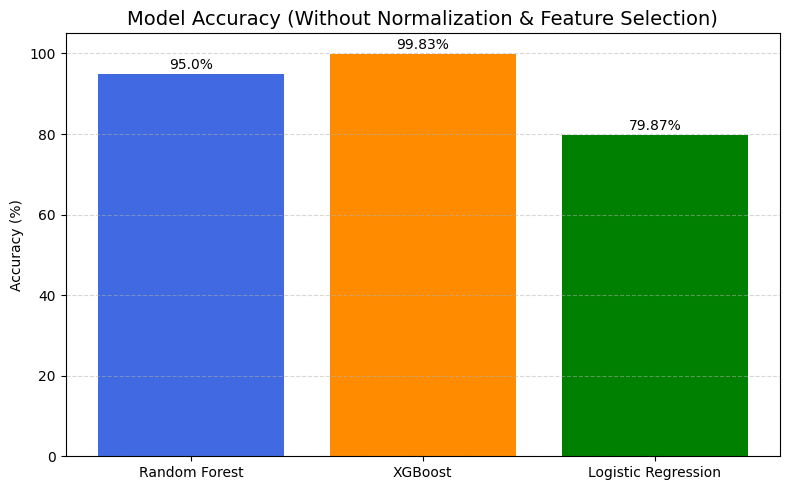

In [ ]:
import matplotlib.pyplot as plt

# Your accuracy results
models = ['Random Forest', 'XGBoost', 'Logistic Regression']
accuracy = [95, 99.83, 79.87]  # Replace if slightly different

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracy, color=['royalblue', 'darkorange', 'green'])

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval}%', ha='center', va='bottom', fontsize=10)

plt.title('Model Accuracy (Without Normalization & Feature Selection)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

WITH NORMALIZATION WITHOUT FEATURE **SELECTION**

MIN MAX **SCALING**

In [ ]:
# Step 1: Import libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 2: Separate features and labels
X = df.drop('label', axis=1)
y = df['label']

# ✅ Make sure y is categorical
y = y.astype('int')

# Step 3: Apply MinMax scaling only to features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 6: Predict and evaluate
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.99831
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     82906
           1       1.00      0.99      1.00     17094

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load your cleaned 5 lakh dataset (update path if needed)
df = pd.read_csv('cleaned_chunk.csv')

# Step 2: Separate features and label
X = df.drop(columns=['label'])  # Assuming 'label' is your target
y = df['label']

# Convert y to discrete values if it's continuous (important for XGBoost)
y = (y > 0.5).astype(int)  # Values above 0.5 become 1, others become 0
# Adjust the threshold (0.5) as needed for your problem

# Step 3: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Apply MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_scaled, y_train)

# Step 6: Predict and Evaluate
y_pred = xgb_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:05:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.94629
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load your cleaned 5 lakh dataset (update path if needed)
df = pd.read_csv('cleaned_chunk.csv')

# Step 2: Separate features and label
X = df.drop(columns=['label'])  # Assuming 'label' is your target
y = df['label']

# Convert y to discrete values if it's continuous (important for Logistic Regression)
y = (y > 0.5).astype(int)  # Values above 0.5 become 1, others become 0
# Adjust the threshold (0.5) as needed for your problem

# Step 3: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Apply MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
logreg_model.fit(X_train_scaled, y_train)

# Step 6: Predict and Evaluate
y_pred = logreg_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.79873
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72     46638
           1       0.73      1.00      0.84     53362

    accuracy                           0.80    100000
   macro avg       0.86      0.78      0.78    100000
weighted avg       0.85      0.80      0.79    100000



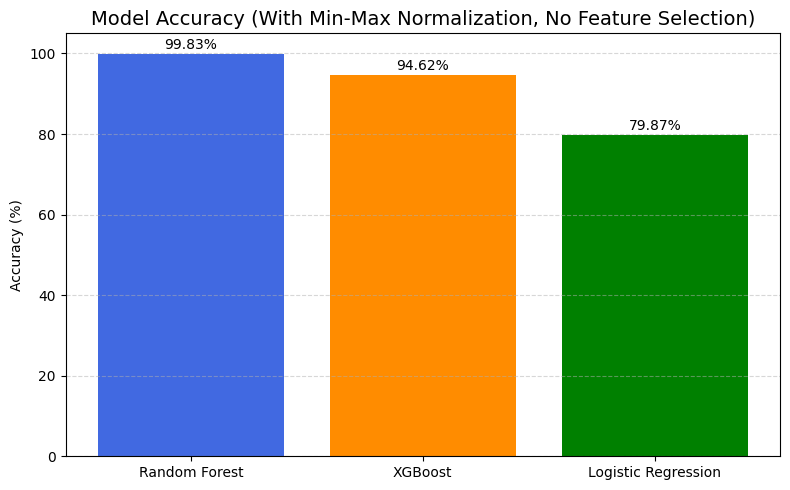

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values (update if needed)
models = ['Random Forest', 'XGBoost', 'Logistic Regression']
accuracy = [99.83, 94.62, 79.87]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracy, color=['royalblue', 'darkorange', 'green'])

# Add accuracy values on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval}%', ha='center', va='bottom', fontsize=10)

plt.title('Model Accuracy (With Min-Max Normalization, No Feature Selection)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**ROBUST SCALER**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load your cleaned 5 lakh dataset (update path if needed)
df = pd.read_csv('cleaned_chunk.csv')

# Step 2: Separate features and label
X = df.drop(columns=['label'])  # Assuming 'label' is your target
y = df['label']

# Convert y to discrete values (if it's continuous)
# Assuming you want to create binary classes based on a threshold:
y = (y > 0.5).astype(int)  # Values above 0.5 become 1, others become 0
# Adjust the threshold (0.5) as needed for your specific problem

# Step 3: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Apply RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Step 6: Predict and Evaluate
y_pred = rf_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.96108
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     46638
           1       0.96      0.97      0.96     53362

    accuracy                           0.96    100000
   macro avg       0.96      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load your cleaned 5 lakh dataset (update path if needed)
df = pd.read_csv('cleaned_chunk.csv')

# Step 2: Separate features and label
X = df.drop(columns=['label'])  # Assuming 'label' is your target
y = df['label']

# Convert y to discrete values if it's continuous (important for XGBoost)
y = (y > 0.5).astype(int)  # Values above 0.5 become 1, others become 0
# Adjust the threshold (0.5) as needed for your problem

# Step 3: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Apply RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_scaled, y_train)

# Step 6: Predict and Evaluate
y_pred = xgb_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:18:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.94628
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load your cleaned 5 lakh dataset (update path if needed)
df = pd.read_csv('cleaned_chunk.csv')

# Step 2: Separate features and label
X = df.drop(columns=['label'])  # Assuming 'label' is your target
y = df['label']

# Convert y to discrete values if it's continuous (important for Logistic Regression)
y = (y > 0.5).astype(int)  # Values above 0.5 become 1, others become 0
# Adjust the threshold (0.5) as needed for your problem

# Step 3: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Apply RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
logreg_model.fit(X_train_scaled, y_train)

# Step 6: Predict and Evaluate
y_pred = logreg_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.79873
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72     46638
           1       0.73      1.00      0.84     53362

    accuracy                           0.80    100000
   macro avg       0.86      0.78      0.78    100000
weighted avg       0.85      0.80      0.79    100000



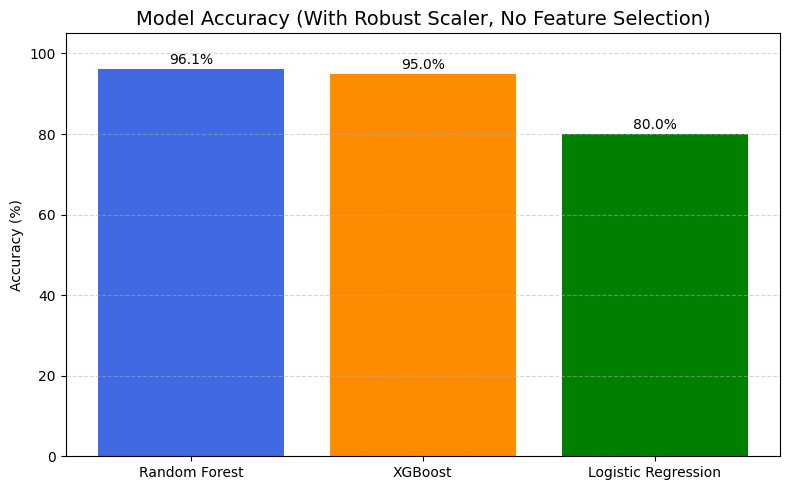

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values (update if needed)
models = ['Random Forest', 'XGBoost', 'Logistic Regression']
accuracy = [96.10, 95, 80]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracy, color=['royalblue', 'darkorange', 'green'])

# Add accuracy values on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval}%', ha='center', va='bottom', fontsize=10)

plt.title('Model Accuracy (With Robust Scaler, No Feature Selection)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**NO NORMALIZATION AND WITH FEATURE SELECTION(FILTER METHODS)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load and preprocess data (including feature selection)
df = pd.read_csv('cleaned_chunk.csv')
corr_matrix = df.drop(columns=['label']).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
filtered_df = df.drop(columns=to_drop)
X = filtered_df.drop(columns=['label'])
y = filtered_df['label']
y = (y > 0.5).astype(int)  # Convert target to discrete if needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred))
print("Random Forest - Classification Report:\n", classification_report(y_test, y_pred))

Random Forest - Accuracy: 0.94634
Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Load and preprocess data (including feature selection)
df = pd.read_csv('cleaned_chunk.csv')
corr_matrix = df.drop(columns=['label']).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
filtered_df = df.drop(columns=to_drop)
X = filtered_df.drop(columns=['label'])
y = filtered_df['label']
y = (y > 0.5).astype(int)  # Convert target to discrete if needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
print("XGBoost - Accuracy:", accuracy_score(y_test, y_pred))
print("XGBoost - Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:20:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.94628
XGBoost - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. Load the dataset
df = pd.read_csv('cleaned_chunk.csv')  # Replace with your actual file name

# 2. Feature Selection (Correlation)
# Remove highly correlated features
corr_matrix = df.drop(columns=['label']).corr().abs()  # Exclude target variable
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]  # Adjust threshold if needed
filtered_df = df.drop(columns=to_drop)

# 3. Separate features and label
X = filtered_df.drop(columns=['label'])
y = filtered_df['label']

# Convert target to discrete values if needed
y = (y > 0.5).astype(int)  # Adjust threshold if needed

# 4. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train Logistic Regression model (without normalization)
logreg_model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
logreg_model.fit(X_train, y_train)

# 6. Predict and Evaluate
y_pred = logreg_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.79873
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72     46638
           1       0.73      1.00      0.84     53362

    accuracy                           0.80    100000
   macro avg       0.86      0.78      0.78    100000
weighted avg       0.85      0.80      0.79    100000



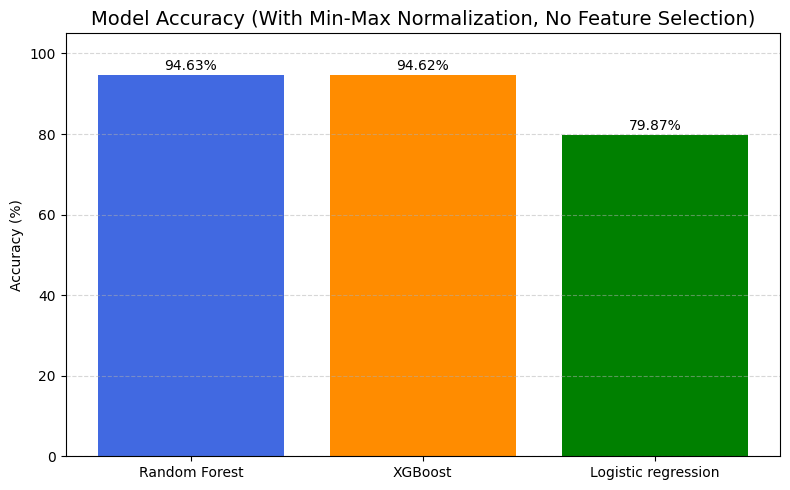

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values (update if needed)
models = ['Random Forest', 'XGBoost' , 'Logistic regression']
accuracy = [94.63, 94.62, 79.87]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracy, color=['royalblue', 'darkorange', 'green'])

# Add accuracy values on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval}%', ha='center', va='bottom', fontsize=10)

plt.title('Model Accuracy (With Min-Max Normalization, No Feature Selection)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**CHI SQUARE METHOD**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)  # Convert target to discrete if needed

# Perform Chi-squared feature selection
chi2_scores, p_values = chi2(X, y)
# Select top k features based on Chi-squared scores (e.g., top 10)
k = 10  # Number of features to select
top_k_features = np.argsort(chi2_scores)[-k:]
selected_features = X.columns[top_k_features]

# Split the dataset using selected features
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred))
print("Random Forest - Classification Report:\n", classification_report(y_test, y_pred))

Random Forest - Accuracy: 0.94633
Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
# Print the selected features
print("Selected Features:", selected_features)

Selected Features: Index(['ts', 'conn_state_RSTR', 'conn_state_S3', 'conn_state_REJ',
       'conn_state_S0', 'proto_icmp', 'proto_tcp', 'conn_state_SF',
       'conn_state_OTH', 'id.orig_h'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# 1. Load the dataset
df = pd.read_csv('cleaned_chunk.csv')  # Replace with your actual file name

# 2. Separate features and label
X = df.drop(columns=['label'])
y = df['label']

# Convert target to discrete values if needed
y = (y > 0.5).astype(int)  # Adjust threshold if needed

# 3. Perform Chi-squared feature selection
chi2_scores, p_values = chi2(X, y)

# Select top k features based on Chi-squared scores (e.g., top 10)
k = 10  # Number of features to select
top_k_features = np.argsort(chi2_scores)[-k:]
selected_features = X.columns[top_k_features]

# 4. Create a dataset with selected features
X_selected = X[selected_features]

# 5. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# 6. Train XGBoost model (without normalization)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# 7. Predict and Evaluate
y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:21:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.94623
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. Load the dataset
df = pd.read_csv('cleaned_chunk.csv')  # Replace with your actual file name

# 2. Separate features and label
X = df.drop(columns=['label'])
y = df['label']

# Convert target to binary values if needed
y = (y > 0.5).astype(int)  # Adjust threshold if needed

# 3. Perform Chi-squared feature selection
chi2_scores, p_values = chi2(X, y)

# Select top k features based on Chi-squared scores (e.g., top 10)
k = 10  # Number of features to select
top_k_features = np.argsort(chi2_scores)[-k:]
selected_features = X.columns[top_k_features]

# 4. Create a dataset with selected features
X_selected = X[selected_features]

# 5. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# 6. Train Logistic Regression model (without normalization)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# 7. Predict and Evaluate
y_pred = lr_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.79873
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72     46638
           1       0.73      1.00      0.84     53362

    accuracy                           0.80    100000
   macro avg       0.86      0.78      0.78    100000
weighted avg       0.85      0.80      0.79    100000



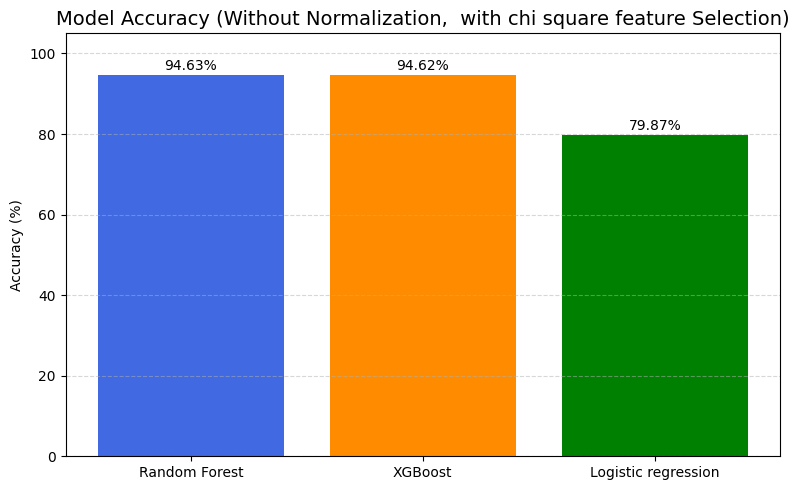

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values (update if needed)
models = ['Random Forest', 'XGBoost' , 'Logistic regression']
accuracy = [94.63, 94.62, 79.87]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracy, color=['royalblue', 'darkorange', 'green'])

# Add accuracy values on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval}%', ha='center', va='bottom', fontsize=10)

plt.title('Model Accuracy (Without Normalization,  with chi square feature Selection)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**RFE**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)  # Convert target to discrete if needed

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE with the Random Forest model and desired number of features
rfe = RFE(estimator=rf_model, n_features_to_select=10)  # Select 10 features

# Fit RFE to the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

# Train the Random Forest model using the selected features
rf_model.fit(X_train[selected_features], y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test[selected_features])
print("Random Forest with RFE - Accuracy:", accuracy_score(y_test, y_pred))
print("Random Forest with RFE - Classification Report:\n", classification_report(y_test, y_pred))

Random Forest with RFE - Accuracy: 0.94634
Random Forest with RFE - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)  # Convert target to binary if needed

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialize RFE with the XGBoost model and desired number of features
rfe = RFE(estimator=xgb_model, n_features_to_select=10)

# Fit RFE to the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]

# Train the XGBoost model using the selected features
xgb_model.fit(X_train[selected_features], y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test[selected_features])
print("XGBoost with RFE - Accuracy:", accuracy_score(y_test, y_pred))
print("XGBoost with RFE - Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:31:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:32:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:32:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:32:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:32:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost with RFE - Accuracy: 0.94628
XGBoost with RFE - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)  # Convert target to binary if needed

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Initialize RFE with Logistic Regression and select top 10 features
rfe = RFE(estimator=lr_model, n_features_to_select=10)

# Fit RFE on training data
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]

# Train Logistic Regression with selected features
lr_model.fit(X_train[selected_features], y_train)

# Predict and evaluate
y_pred = lr_model.predict(X_test[selected_features])
print("Logistic Regression with RFE - Accuracy:", accuracy_score(y_test, y_pred))
print("Logistic Regression with RFE - Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression with RFE - Accuracy: 0.79873
Logistic Regression with RFE - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72     46638
           1       0.73      1.00      0.84     53362

    accuracy                           0.80    100000
   macro avg       0.86      0.78      0.78    100000
weighted avg       0.85      0.80      0.79    100000



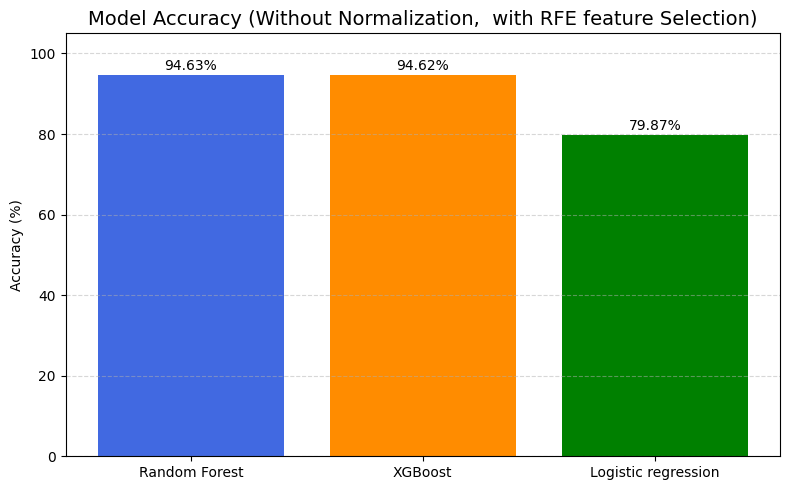

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values (update if needed)
models = ['Random Forest', 'XGBoost' , 'Logistic regression']
accuracy = [94.63, 94.62, 79.87]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracy, color=['royalblue', 'darkorange', 'green'])

# Add accuracy values on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval}%', ha='center', va='bottom', fontsize=10)

plt.title('Model Accuracy (Without Normalization,  with RFE feature Selection)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**WITH RFE FEATURE SELECTION AND MIN MAX SCALER**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)  # Convert to binary classification if not already

# Normalize features using Min-Max Scaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply RFE to select top 10 features
rfe = RFE(estimator=rf_model, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]

# Train Random Forest using selected features
rf_model.fit(X_train[selected_features], y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test[selected_features])
print("Random Forest with RFE + MinMax Scaling - Accuracy:", accuracy_score(y_test, y_pred))
print("Random Forest with RFE + MinMax Scaling - Classification Report:\n", classification_report(y_test, y_pred))


Random Forest with RFE + MinMax Scaling - Accuracy: 0.94634
Random Forest with RFE + MinMax Scaling - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



**RFE WITH ROBUST SCALER**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)  # Ensure binary classification

# Apply Robust Scaler normalization
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply RFE (wrapper method) with RF to select top 10 features
rfe = RFE(estimator=rf_model, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Extract selected features
selected_features = X_train.columns[rfe.support_]

# Train Random Forest on selected features
rf_model.fit(X_train[selected_features], y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test[selected_features])
print("Random Forest with RFE + Robust Scaler - Accuracy:", accuracy_score(y_test, y_pred))
print("Random Forest with RFE + Robust Scaler - Classification Report:\n", classification_report(y_test, y_pred))


Random Forest with RFE + Robust Scaler - Accuracy: 0.9611
Random Forest with RFE + Robust Scaler - Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     46638
           1       0.96      0.97      0.96     53362

    accuracy                           0.96    100000
   macro avg       0.96      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000



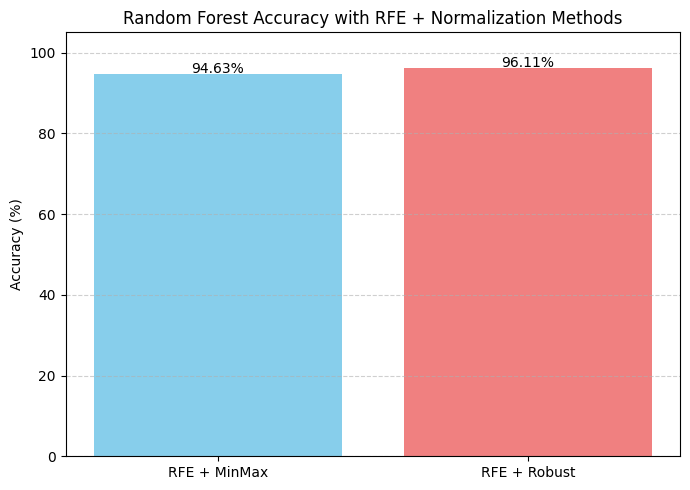

In [ ]:
import matplotlib.pyplot as plt

methods = ['RFE + MinMax', 'RFE + Robust']
accuracy = [94.63, 96.11]

plt.figure(figsize=(7, 5))
bars = plt.bar(methods, accuracy, color=['skyblue', 'lightcoral'])

# Add labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.3, f'{yval}%', ha='center', fontsize=10)

plt.title('Random Forest Accuracy with RFE + Normalization Methods')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**XGBOOST WITH RFE AND MINMAX**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)  # Ensure binary classification

# Apply Min-Max scaling
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Apply RFE to select top 10 features
rfe = RFE(estimator=xgb_model, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]

# Train XGBoost on selected features
xgb_model.fit(X_train[selected_features], y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test[selected_features])
print("XGBoost with RFE + MinMax Scaler - Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:50:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:50:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:50:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:50:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:50:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost with RFE + MinMax Scaler - Accuracy: 0.94628
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
from sklearn.preprocessing import RobustScaler

# Apply Robust scaling
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Apply RFE to select top 10 features
rfe = RFE(estimator=xgb_model, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]

# Train XGBoost on selected features
xgb_model.fit(X_train[selected_features], y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test[selected_features])
print("XGBoost with RFE + Robust Scaler - Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:50:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:50:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:50:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:51:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:51:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost with RFE + Robust Scaler - Accuracy: 0.94629
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)  # Ensure binary classification

# Apply Robust Scaler normalization
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Apply RFE with Logistic Regression to select top 10 features
rfe = RFE(estimator=lr_model, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]

# Train Logistic Regression on selected features
lr_model.fit(X_train[selected_features], y_train)

# Predict and evaluate
y_pred = lr_model.predict(X_test[selected_features])
print("Logistic Regression with RFE + Robust Scaler - Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression with RFE + Robust Scaler - Accuracy: 0.79873
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72     46638
           1       0.73      1.00      0.84     53362

    accuracy                           0.80    100000
   macro avg       0.86      0.78      0.78    100000
weighted avg       0.85      0.80      0.79    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)  # Ensure binary classification

# Apply Min-Max Scaler normalization
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Apply RFE with Logistic Regression to select top 10 features
rfe = RFE(estimator=lr_model, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]

# Train Logistic Regression on selected features
lr_model.fit(X_train[selected_features], y_train)

# Predict and evaluate
y_pred = lr_model.predict(X_test[selected_features])
print("Logistic Regression with RFE + MinMax Scaler - Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression with RFE + MinMax Scaler - Accuracy: 0.79873
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72     46638
           1       0.73      1.00      0.84     53362

    accuracy                           0.80    100000
   macro avg       0.86      0.78      0.78    100000
weighted avg       0.85      0.80      0.79    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)

# Min-Max Scaling (required for chi2)
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Chi-Square Feature Selection (top 10 features)
selector = SelectKBest(score_func=chi2, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(X_selected, columns=selected_features), y, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Results
print("Random Forest + Chi-Square + MinMax - Accuracy:", accuracy_score(y_test, y_pred))
print("Selected Features:", list(selected_features))
print("Classification Report:\n", classification_report(y_test, y_pred))


Random Forest + Chi-Square + MinMax - Accuracy: 0.94632
Selected Features: ['ts', 'id.orig_h', 'proto_icmp', 'proto_tcp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTR', 'conn_state_S0', 'conn_state_S3', 'conn_state_SF']
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)

# Min-Max Scaling (required for chi2)
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Chi-Square Feature Selection (top 10 features)
selector = SelectKBest(score_func=chi2, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(X_selected, columns=selected_features), y, test_size=0.2, random_state=42)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Results
print("Logistic Regression + Chi-Square + MinMax - Accuracy:", accuracy_score(y_test, y_pred))
print("Selected Features:", list(selected_features))
print("Classification Report:\n", classification_report(y_test, y_pred))


Logistic Regression + Chi-Square + MinMax - Accuracy: 0.79873
Selected Features: ['ts', 'id.orig_h', 'proto_icmp', 'proto_tcp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTR', 'conn_state_S0', 'conn_state_S3', 'conn_state_SF']
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72     46638
           1       0.73      1.00      0.84     53362

    accuracy                           0.80    100000
   macro avg       0.86      0.78      0.78    100000
weighted avg       0.85      0.80      0.79    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)

# Min-Max Scaling (required for chi2)
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Chi-Square Feature Selection (top 10 features)
selector = SelectKBest(score_func=chi2, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(X_selected, columns=selected_features), y, test_size=0.2, random_state=42)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Results
print("XGBoost + Chi-Square + MinMax - Accuracy:", accuracy_score(y_test, y_pred))
print("Selected Features:", list(selected_features))
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:53:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost + Chi-Square + MinMax - Accuracy: 0.94623
Selected Features: ['ts', 'id.orig_h', 'proto_icmp', 'proto_tcp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTR', 'conn_state_S0', 'conn_state_S3', 'conn_state_SF']
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)

# Apply Robust Scaler
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Shift to make values non-negative (chi2 requires this)
X_shifted = X_scaled - X_scaled.min()

# Chi-Square Feature Selection (top 10 features)
selector = SelectKBest(score_func=chi2, k=10)
X_selected = selector.fit_transform(X_shifted, y)
selected_features = X.columns[selector.get_support()]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(X_selected, columns=selected_features), y, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Results
print("Random Forest + Chi-Square + Robust Scaler - Accuracy:", accuracy_score(y_test, y_pred))
print("Selected Features:", list(selected_features))
print("Classification Report:\n", classification_report(y_test, y_pred))

Random Forest + Chi-Square + Robust Scaler - Accuracy: 0.94634
Selected Features: ['ts', 'id.orig_h', 'proto_icmp', 'proto_tcp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTR', 'conn_state_S0', 'conn_state_S3', 'conn_state_SF']
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)

# Apply Robust Scaler
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Shift to ensure all values are non-negative
X_shifted = X_scaled - X_scaled.min()

# Chi-Square Feature Selection (top 10 features)
selector = SelectKBest(score_func=chi2, k=10)
X_selected = selector.fit_transform(X_shifted, y)
selected_features = X.columns[selector.get_support()]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(X_selected, columns=selected_features), y, test_size=0.2, random_state=42)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Results
print("Logistic Regression + Chi-Square + Robust Scaler - Accuracy:", accuracy_score(y_test, y_pred))
print("Selected Features:", list(selected_features))
print("Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression + Chi-Square + Robust Scaler - Accuracy: 0.79873
Selected Features: ['ts', 'id.orig_h', 'proto_icmp', 'proto_tcp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTR', 'conn_state_S0', 'conn_state_S3', 'conn_state_SF']
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72     46638
           1       0.73      1.00      0.84     53362

    accuracy                           0.80    100000
   macro avg       0.86      0.78      0.78    100000
weighted avg       0.85      0.80      0.79    100000



In [ ]:
#CHI SQUARE WITH ROBUST FOR XGBOOST
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = df['label']
y = (y > 0.5).astype(int)

# Apply Robust Scaler
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Shift to ensure all values are non-negative (required for chi2)
X_shifted = X_scaled - X_scaled.min()

# Chi-Square Feature Selection (top 10 features)
selector = SelectKBest(score_func=chi2, k=10)
X_selected = selector.fit_transform(X_shifted, y)
selected_features = X.columns[selector.get_support()]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(X_selected, columns=selected_features), y, test_size=0.2, random_state=42)

# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Results
print("XGBoost + Chi-Square + Robust Scaler - Accuracy:", accuracy_score(y_test, y_pred))
print("Selected Features:", list(selected_features))
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:53:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost + Chi-Square + Robust Scaler - Accuracy: 0.94625
Selected Features: ['ts', 'id.orig_h', 'proto_icmp', 'proto_tcp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTR', 'conn_state_S0', 'conn_state_S3', 'conn_state_SF']
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
#CORRELATION + ROBUST SCALER RANDOM FOREST
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load and preprocess
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = (df['label'] > 0.5).astype(int)

# Correlation-based feature selection
correlations = X.corrwith(y).abs()
top_features = correlations.sort_values(ascending=False).head(10).index
X_selected = X[top_features]

# Robust Scaling
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_selected), columns=top_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluation
print("Random Forest (Robust + Correlation) - Accuracy:", accuracy_score(y_test, y_pred))
print("Selected Features:", list(top_features))
print("Classification Report:\n", classification_report(y_test, y_pred))

Random Forest (Robust + Correlation) - Accuracy: 0.96108
Selected Features: ['id.orig_h', 'proto_tcp', 'conn_state_S0', 'conn_state_OTH', 'conn_state_SF', 'proto_icmp', 'conn_state_REJ', 'conn_state_S3', 'ts', 'conn_state_RSTR']
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     46638
           1       0.96      0.97      0.96     53362

    accuracy                           0.96    100000
   macro avg       0.96      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000



In [ ]:
#CORRELATION+ROBUST (XGB)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load and preprocess
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = (df['label'] > 0.5).astype(int)

# Correlation-based feature selection
correlations = X.corrwith(y).abs()
top_features = correlations.sort_values(ascending=False).head(10).index
X_selected = X[top_features]

# Robust Scaling
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_selected), columns=top_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Evaluation
print("XGBoost (Robust + Correlation) - Accuracy:", accuracy_score(y_test, y_pred))
print("Selected Features:", list(top_features))
print("Classification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:59:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (Robust + Correlation) - Accuracy: 0.94624
Selected Features: ['id.orig_h', 'proto_tcp', 'conn_state_S0', 'conn_state_OTH', 'conn_state_SF', 'proto_icmp', 'conn_state_REJ', 'conn_state_S3', 'ts', 'conn_state_RSTR']
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     46638
           1       0.91      1.00      0.95     53362

    accuracy                           0.95    100000
   macro avg       0.95      0.94      0.95    100000
weighted avg       0.95      0.95      0.95    100000



In [ ]:
#CORRELATION WITH ROBUST (LR)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load and preprocess
df = pd.read_csv('cleaned_chunk.csv')
X = df.drop(columns=['label'])
y = (df['label'] > 0.5).astype(int)

# Correlation-based feature selection
correlations = X.corrwith(y).abs()
top_features = correlations.sort_values(ascending=False).head(10).index
X_selected = X[top_features]

# Robust Scaling
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_selected), columns=top_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Evaluation
print("Logistic Regression (Robust + Correlation) - Accuracy:", accuracy_score(y_test, y_pred))
print("Selected Features:", list(top_features))
print("Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression (Robust + Correlation) - Accuracy: 0.79873
Selected Features: ['id.orig_h', 'proto_tcp', 'conn_state_S0', 'conn_state_OTH', 'conn_state_SF', 'proto_icmp', 'conn_state_REJ', 'conn_state_S3', 'ts', 'conn_state_RSTR']
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.72     46638
           1       0.73      1.00      0.84     53362

    accuracy                           0.80    100000
   macro avg       0.86      0.78      0.78    100000
weighted avg       0.85      0.80      0.79    100000

